> Projeto Desenvolve <br>
Programação Intermediária com Python <br>
Profa. Camila Laranjeira (mila@projetodesenvolve.com.br) <br>

# 4.2 - APIs


## Exercícios 🔭🌌🪐

Vamos acessar as APIs da NASA para ver algumas imagens interessantes capturadas universo afora!

#### Q1.
Crie uma chave no site oficial:
* https://api.nasa.gov

Vamos armazenar a chave de forma segura! <br>
Salve a sua chave em um arquivo `key.json` na forma:
`API_KEY=SUA_CHAVE`

Adicione o nome do arquivo `key.json` ao `.gitignore` do repositório que você fará upload da atividade.
Para isso basta abrir o arquivo `.gitignore` na pasta raíz do repositório (ou criar um caso ele não exista). Dentro do arquivo, apenas adiciona o nome do arquivo que deseja ignorar.

In [3]:
# Célula 1 — Carregar a chave da NASA com segurança
from pathlib import Path
import json

def load_api_key(path="key.json"):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError("Arquivo key.json não encontrado na mesma pasta do notebook.")
    text = p.read_text().strip()
    # Aceitar tanto formato KEY=VAL quanto JSON {"API_KEY":"..."} se você preferir
    if text.startswith("{"):
        data = json.loads(text)
        key = data.get("API_KEY") or data.get("api_key")
    else:
        lines = [ln for ln in text.splitlines() if "=" in ln and not ln.strip().startswith("#")]
        kv = dict(ln.split("=", 1) for ln in lines)
        key = (kv.get("API_KEY") or kv.get("api_key") or "").strip()
    if not key:
        raise ValueError("Não encontrei API_KEY dentro do key.json.")
    return key

NASA_API_KEY = load_api_key()
print("Chave carregada com sucesso (não exibida por segurança).")


Chave carregada com sucesso (não exibida por segurança).


#### Q2. 🛰 Astronomy Picture of the Day (APOD) 🌌
> Antes de fazer os exercícios, devo te lembrar que existem limites de acesso às APIs, descritas na página principal, portanto pega leve na tentativa e erro na hora de testar seu código.

<img width=500 src=https://apod.nasa.gov/apod/image/2407/M24-HaLRGB-RC51_1024.jpg>

A primeira API que acessaremos é a mais popular de todas: astronomy picture of the day (foto astronômica do dia).

Faça uma requisição GET para a URL da API que retorna a imagem do dia! Essa é fácil já que são os valores padrão da rota principal:
* URL base: `'https://api.nasa.gov/planetary/apod'`
* Endpoint: não precisa preencher, acessaremos a raíz da API.
* Query params: preencha `api_key` com a sua chave de autenticação. Se animar mexer em outros parâmetros veja [a documentação](https://api.nasa.gov).

Ao receber a resposta (um json), você deve:
* Imprimir os campos `copyright` e `explanation`
* Com as biblioteca scikit-images e matplotlib, apresente a imagem a partir do campo `url` ou `hdurl`, e preencha o título do plot com o campo `title` do json. Uma dica de código a seguir.
```python
from skimage import io
img = io.imread(url)
## plot a matriz img com matplotlib (imshow)
```   

📜 Copyright: Adam Block
📝 Explanation: Over 500,000 light years across, NGC 6872 (bottom left) is a truly enormous barred spiral galaxy. At least 5 times the size of our own large Milky Way, NGC 6872 is the largest known spiral galaxy. About 200 million light-years distant toward the southern constellation Pavo, the Peacock, the appearance of this giant galaxy's stretched out spiral arms suggest the wings of a giant bird. So its popular moniker is the Condor galaxy. Lined with massive young, bluish star clusters and star-forming regions, the extended and distorted spiral arms are due to NGC 6872's past gravitational interactions with the nearby smaller galaxy IC 4970, visible here below the giant spiral galaxy's core. Other members of the southern Pavo galaxy group are scattered through this magnificent galaxy group portrait, with the dominant giant elliptical galaxy, NGC 6876, above and right of the soaring Condor galaxy.
🔗 URL da imagem: https://apod.nasa.gov/apod/image/2508/NGC6872_

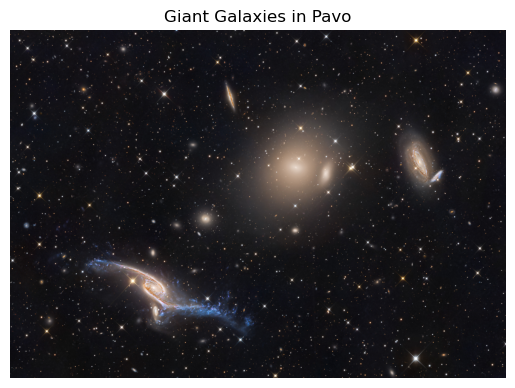

In [27]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# URL base
url = "https://api.nasa.gov/planetary/apod"

# Requisição GET
response = requests.get(url, params={"api_key": NASA_API_KEY})
data = response.json()

print("📜 Copyright:", data.get("copyright", "N/A"))
print("📝 Explanation:", data["explanation"])

# Baixar imagem
img_url = data.get("hdurl") or data.get("url")
print("🔗 URL da imagem:", img_url)

img_response = requests.get(img_url)
img = Image.open(BytesIO(img_response.content))

# Exibir imagem
plt.imshow(img)
plt.axis("off")
plt.title(data["title"])
plt.show()


#### Q3. Limites
A partir da resposta da query anterios, imprima o header da resposta e consulte os atributos:
* X-RateLimit-Limit: o limite total de requisições da sua chave de API
* X-RateLimit-Remaining: o limite restante de requisições da sua chave de API

In [30]:
# Q3 — Limites da API
print("📊 Limites da sua chave de API:")

print("X-RateLimit-Limit:", response.headers.get("X-RateLimit-Limit"))
print("X-RateLimit-Remaining:", response.headers.get("X-RateLimit-Remaining"))


📊 Limites da sua chave de API:
X-RateLimit-Limit: 4000
X-RateLimit-Remaining: 3999


### Q4. Mars Rover Photos 🚀🚙 📷

<img width=500 src=https://www.nasa.gov/wp-content/uploads/2019/10/pia23378-16.jpg>

Essa API retorna dados (incluindo imagens capturadas) sobre os veículos que hoje habitam o planeta Marte. São os rovers `opportunity`, `spirit` e o mais famoso, o `curiosity` (da foto acima).

Antes de requisitar imagens, vamos ver o relatório de dados coletados por um deles, o `curiosity`. Isso vai nos ajudar a montar a query de imagens coletadas.

Faça uma requisição GET para a seguinte URL:
* URL base: `'https://api.nasa.gov/mars-photos/api/v1'`
* endpoint: `'/manifests/{nome_do_rover}'`
* query parameters: preencha `api_key` com a sua chave de autenticação.

Extraia o json da resposta retornada. O campo principal é o `'photo_manifest'`, do qual queremos acessar os seguintes valores:
* `max_sol`: Máximo "dia marciano" de coleta de fotos. O dia marciano tem 24 horas, 39 minutos e 35 segundos.
* `max_date`: Última data terrestre de coleta de fotos, na forma `'aaaa-mm-dd'`.

Imprima esses dois atributos da resposta e os use no próximo exercício para coletar as fotos mais recentes tiradas. 

In [32]:
# Q4 — Manifesto do rover Curiosity
import requests

base_url = "https://api.nasa.gov/mars-photos/api/v1"
endpoint = "/manifests/curiosity"

resp = requests.get(base_url + endpoint, params={"api_key": NASA_API_KEY})
resp.raise_for_status()

manifest = resp.json()["photo_manifest"]

print("Rover:", manifest["name"])
print("Max Sol (último dia marciano):", manifest["max_sol"])
print("Max Date (última data terrestre):", manifest["max_date"])


Rover: Curiosity
Max Sol (último dia marciano): 4633
Max Date (última data terrestre): 2025-08-18


#### Q5.

Faça uma requisição GET para a URL da API que retorna links para as imagens coletadas pelos rovers.

* URL base: `'https://api.nasa.gov/mars-photos/api/v1'`
* Endpoint: `/rovers/{nome_do_rover}/photos`
* Query params sugeridos: 
    * `api_key`: sua chave de autenticação.
    * `sol`: dia marciano que deseja coletar (de 0 a `max_sol` coletado anteriormente)
    * `page`: você pode paginar entre as respostas! São retornados 25 resultados por página.

A resposta esperada estará no formato a seguir, uma lista no campo `'photos'` onde cada item é um dicionário com os dados da foto tirada. Dentre os dados há o campo `camera` indicando qual das câmeras do rover tirou a foto. As fotos mais interessantes (na minha opinião, claro) são das câmeras de navegação (`"name": "NAVCAM"`) e as de prevenção de colisão (frente: `"name": "FHAZ"` e trás `"name": "RHAZ"`) onde dá pra ver partes do robô!

**Seu trabalho é**:
* Paginar a requisição acima até que a resposta seja `None`
* Escolher uma ou mais câmeras (ex: `NAVCAM`, `FHAZ`, `RHAZ`), e em um laço de repetição plotar todas as imagens retornadas daquela câmera. Use novamente as bibliotecas scikit-image e matplotlib. 
  * O título da imagem deve ter a página da requisição, nome da câmera e id da imagem.

```json
{
  "photos": [
    {
      "id": 1228212,
      "sol": 4102,
      "camera": {
        "id": 20,
        "name": "FHAZ",
        "rover_id": 5,
        "full_name": "Front Hazard Avoidance Camera"
      },
      "img_src": "https://mars.nasa.gov/msl-raw-images/proj/msl/redops/ods/surface/sol/04102/opgs/edr/fcam/FLB_761645828EDR_F1060660FHAZ00302M_.JPG",
      "earth_date": "2024-02-19",
      "rover": {
        "id": 5,
        "name": "Curiosity",
        ...
      }
    }
    {
      "id": 1228213,
      "sol": 4102, 
      ...
    }
```



In [37]:
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

sol = manifest["max_sol"]   # usamos o valor coletado na Q4
page = 1

while True:
    print(f"\n🔎 Buscando página {page} do sol {sol}...")
    photos_resp = requests.get(
        f"{base_url}/rovers/curiosity/photos",
        params={"api_key": NASA_API_KEY, "sol": sol, "page": page}
    )
    photos_resp.raise_for_status()
    photos_data = photos_resp.json()["photos"]

    # Se não houver fotos nessa página, parar o loop
    if not photos_data:
        print("❌ Não há mais fotos para mostrar.")
        break

    # Filtrar apenas câmeras interessantes
    for photo in photos_data:
        cam = photo["camera"]["name"]
        if cam in ["NAVCAM", "FHAZ", "RHAZ"]:
            img_url = photo["img_src"]
            print(f"📷 Câmera: {cam} | ID: {photo['id']} | Data: {photo['earth_date']}")

            # baixar a imagem
            img_bytes = requests.get(img_url).content
            img = Image.open(BytesIO(img_bytes))

            # exibir
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Página {page} | {cam} | ID {photo['id']}")
            plt.show()

    # passar para a próxima página
    page += 1



🔎 Buscando página 1 do sol 4633...

🔎 Buscando página 2 do sol 4633...

🔎 Buscando página 3 do sol 4633...
❌ Não há mais fotos para mostrar.
